# 3. Clustering Around Medoids with Resample Exposure

In this example, we will demonstrate how resample exposure can be used for clustering around medoids in heterogeneous data. 

# 3.1 Visualising clustering around medoids

In the first part we check that resample exposure is able to find convincing clusters in a simple real-world dataset. We project the results into 2D space using PCA and visualize the clusters formed on the penguins dataset.


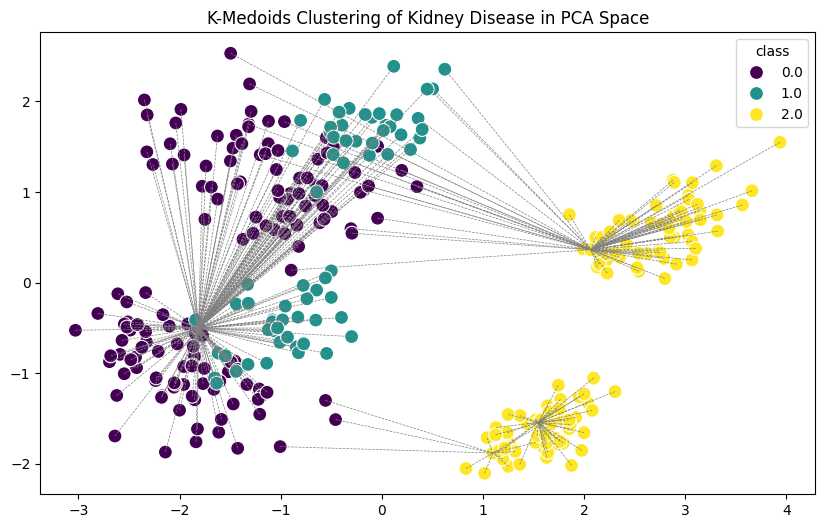

In [ ]:
### Imports
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids

from rex_score.resample_exposure import ResampleExposure
from experiments.prepare_data import preprocess_data

df = sns.load_dataset('penguins')
df,_,_ = preprocess_data(df, 'species')

df_x, df_y = df.drop(columns=['class']), df['class']

rex = ResampleExposure(df_x)
exposure_matrix = rex.resample_exposure_matrix(normalised=True)
exposure_matrix = np.ones_like(exposure_matrix)  - exposure_matrix  # Invert the exposure matrix for PCA

kmedoids = KMedoids(n_clusters=4, random_state=42, metric='precomputed')
kmedoids.fit(exposure_matrix)

# import gower
# gower_matrix = gower.gower_matrix(df_x)

# kmedoids = KMedoids(n_clusters=4, random_state=42, metric='precomputed')
# kmedoids.fit(gower_matrix)

# kmedoids = KMedoids(n_clusters=4, random_state=42, metric='euclidean')
# kmedoids.fit(df_x)

labels = kmedoids.labels_

# plot the data in principal component space
pca = PCA(n_components=2)
X_std = (df_x - df_x.mean()) / df_x.std()
pca_result = pca.fit_transform(X_std)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df_y, palette='viridis', s=100)
plt.title('K-Medoids Clustering of Kidney Disease in PCA Space')

## draw lines between the points and the medoids
for i, medoid in enumerate(kmedoids.medoid_indices_):
    medoid_pca = pca_result[medoid].reshape(1, -1)

    for j in range(len(pca_result[labels == i])):
        plt.plot([pca_result[labels == i][j, 0], medoid_pca[0, 0]], 
                 [pca_result[labels == i][j, 1], medoid_pca[0, 1]], 
                 color='gray', linestyle='--', linewidth=0.5)

Next we check the result in the context of the competition, namely, Eucledian, Gower, HEOM, GEM.

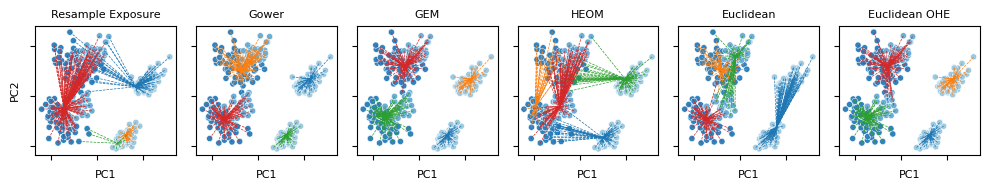

In [6]:
import seaborn as sns

from experiments.plots import plot_clustering_subplots
from experiments.prepare_data import preprocess_data

from experiments.KNN_adapters import (
    eucledian_kmedoids,
    eucledian_kmedoids_OHE,
    gower_kmedoids,
    gem_kmedoids,
    heom_kmedoids,
    resample_exposure_kmedoids
)

df = sns.load_dataset('penguins')
df,_,_ = preprocess_data(df, 'species')

# Define the metrics to use for clustering
metrics = {
    'Resample Exposure': resample_exposure_kmedoids,
    'Gower': gower_kmedoids,
    'GEM': gem_kmedoids,
    'HEOM': heom_kmedoids,
    'Euclidean': eucledian_kmedoids,
    'Euclidean OHE': eucledian_kmedoids_OHE,
}

# Plot the clustering results
plot_clustering_subplots(df, metrics, n_clusters=4, seed=40)

It appers that resample exposure is able to identify convincing clusters, that are meaningfull and different from those found by the other techniques. 

# 3.2 Creating artificial data
Our main experiment for clustering involves artificial data. This is to circumvent a major challange of objective clustering evaluation in datasets, without using distance measures. 

In the following we show an example of how we create the synthetic data. 

In [12]:
### Import data generators from experiments scrips
import pandas as pd

from experiments.prepare_data import replace_features_with_gmm_category
from experiments.data_generators import data_generator10, data_generator14, data_generator12

In [13]:
# First use the generator to create a dataset with 6 (continous) features
Medium_Balanced_X, Medium_Balanced_y = data_generator12(n_blobs=3, n_moons=2, dim=12, n_samples_per_cluster=200)

# Next we use the converter to convert continous features into a category using GMMs. 
# The new feature is added at the end of the dataset.
Medium_Balanced_X, Medium_Balanced_y = replace_features_with_gmm_category(Medium_Balanced_X, Medium_Balanced_y, 1, 2, n_components=6)
Medium_Balanced_X, Medium_Balanced_y = replace_features_with_gmm_category(Medium_Balanced_X, Medium_Balanced_y, 1, 2, n_components=3)
Medium_Balanced_X, Medium_Balanced_y = replace_features_with_gmm_category(Medium_Balanced_X, Medium_Balanced_y, 1, 2, n_components=4)
Medium_Balanced_X, Medium_Balanced_y = replace_features_with_gmm_category(Medium_Balanced_X, Medium_Balanced_y, 1, 2, n_components=5)
Medium_Balanced_X = pd.DataFrame(Medium_Balanced_X)

# Show the first few rows of the dataset
Medium_Balanced_X.head()

,0,1,2,3,4,5,6,7
0,-7.749000,0.850564,-0.430758,2.223623,0.0,0.0,3.0,1.0
1,10.464922,0.245609,1.084701,-0.485879,1.0,1.0,2.0,0.0
2,10.301036,1.962695,0.087351,-2.200554,1.0,1.0,2.0,0.0
3,9.664359,-0.266919,0.713917,1.821015,1.0,1.0,0.0,0.0
4,-3.076236,-0.226191,-1.820092,0.005036,0.0,0.0,1.0,1.0


In [ ]:
### Here we show how we make a dataset with also 8 total features, but where the majority are numerical features
Medium_Reals_X, Medium_Reals_y = data_generator10(n_blobs=3, n_moons=2, dim=10, n_samples_per_cluster=200)
Medium_Reals_X, Medium_Reals_y = replace_features_with_gmm_category(Medium_Reals_X, Medium_Reals_y, 1, 2, n_components=3)
Medium_Reals_X, Medium_Reals_y = replace_features_with_gmm_category(Medium_Reals_X, Medium_Reals_y, 1, 2, n_components=5)
Medium_Reals_X = pd.DataFrame(Medium_Reals_X)

Medium_Reals_X.head()

,0,1,2,3,4,5,6,7
0,-3.321160,2.920944,4.540590,-0.350589,0.267925,-0.557710,2.0,3.0
1,9.247642,-0.313375,0.671611,-0.751363,-0.743070,-0.435220,1.0,1.0
2,11.679973,0.439434,0.974671,-1.379491,-2.447749,0.128768,1.0,1.0
3,8.782836,-0.978735,-1.292903,0.995986,-0.334622,-0.154288,1.0,1.0
4,-6.601784,3.064174,6.444463,3.117578,2.865075,-2.079011,2.0,3.0


In [15]:
### And here the same, but for a dataset with mostly categorical features
# Notice that we need to generate a larger dataset to begin with and use the converter more times.
Medium_Cats_X, Medium_Cats_y = data_generator14(n_blobs=3, n_moons=2, dim=14, n_samples_per_cluster=200)
Medium_Cats_X, Medium_Cats_y = replace_features_with_gmm_category(Medium_Cats_X, Medium_Cats_y, 1, 2, n_components=2)
Medium_Cats_X, Medium_Cats_y = replace_features_with_gmm_category(Medium_Cats_X, Medium_Cats_y, 1, 2, n_components=3)
Medium_Cats_X, Medium_Cats_y = replace_features_with_gmm_category(Medium_Cats_X, Medium_Cats_y, 1, 2, n_components=4)
Medium_Cats_X, Medium_Cats_y = replace_features_with_gmm_category(Medium_Cats_X, Medium_Cats_y, 1, 2, n_components=5)
Medium_Cats_X, Medium_Cats_y = replace_features_with_gmm_category(Medium_Cats_X, Medium_Cats_y, 1, 2, n_components=3)
Medium_Cats_X, Medium_Cats_y = replace_features_with_gmm_category(Medium_Cats_X, Medium_Cats_y, 1, 2, n_components=5)
Medium_Cats_X = pd.DataFrame(Medium_Cats_X)

Medium_Cats_X.head()

,0,1,2,3,4,5,6,7
0,-5.216372,0.406792,0.0,0.0,1.0,0.0,2.0,1.0
1,10.541220,0.169301,1.0,1.0,2.0,1.0,0.0,0.0
2,9.314859,1.573308,1.0,1.0,3.0,1.0,0.0,0.0
3,9.898906,-0.030937,1.0,1.0,0.0,1.0,0.0,1.0
4,-4.881733,-1.685780,0.0,0.0,1.0,1.0,2.0,1.0


We note that even though the added categorical features appear to be ordered, the generating algorithm assings the values randomly to the modes identified by the GMM. Hence there is no inherent order in the categorical features. 

## 3.3 Repeated experiments over the artificial datasets
In this section we run the clustering algorithm on the artificial datasets, and compare the results with the ground truth.
We use resample exposure, eucledian distance, eucledian distance with one-hot encoding, gower distance, HEOM distance, and GEM distance. The process is repeated 50 timed for each dataset and each distance measure.

The experiments are run by the script [03_medoids_exp.py](experiments/03_medoids_exp.py). The results are saved in the [results](experiments/results/03_clustering_scores.json) folder.

In [7]:
import json

# Reading the dictionary from json
with open('experiments/results/03_clustering_scores.json', 'r') as f:
    Dataset_Scores = json.load(f)

In [8]:
import pandas as pd

# Flatten the nested dictionary into a DataFrame
rows = []
for measure in ['ARI', 'NMI']:
    for dataset_size in ['Large', 'Medium', 'Small']:
        for data_type in ['Reals', 'Cats', 'Balanced']:
            for metric in ['REX', 'GOW', 'GEM', 'HEOM', 'L2', 'L2_OHE']:
                values = Dataset_Scores[measure][dataset_size][data_type][metric]
                for val in values:
                    rows.append({
                        'measure': measure,   # 'ARI' or 'NMI'
                        'dims': dataset_size,  # 'Large', 'Medium', 'Small'
                        'size': data_type,     # 'Reals', 'Cats', 'Balanced'
                        'metric': metric,      # e.g., 'gem'
                        'result': val          # numerical score
                    })

res_dataframe = pd.DataFrame(rows)

res_dataframe.head()

,measure,dims,size,metric,result
0,ARI,Large,Reals,REX,0.555258
1,ARI,Large,Reals,REX,0.353056
2,ARI,Large,Reals,REX,0.628612
3,ARI,Large,Reals,REX,0.330891
4,ARI,Large,Reals,REX,0.379416


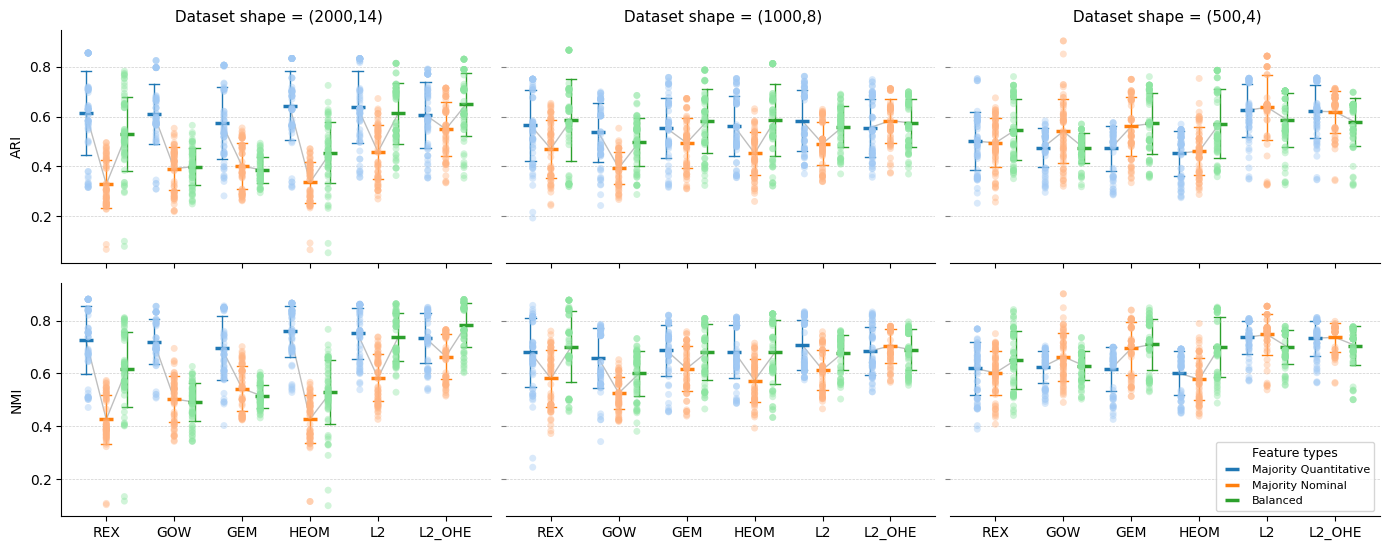

In [9]:
### Figure 5 in the paper
from experiments.plots import plot_clustering_scores_artificial_data

plot_clustering_scores_artificial_data(res_dataframe)